not implemented yet


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import predict_downstream_reduced_rank_regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions


,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
108,Z:\Data\FujisawaS\EE\EE0705fm
109,Z:\Data\FujisawaS\EE\EE0706fm
110,Z:\Data\FujisawaS\EE\EE0708fm
111,Z:\Data\HMC1\day12


In [6]:
def get_data(basepath, target_regions, reference_region, ripple_expand):
    st, cm = loading.load_spikes(
        basepath, brainRegion=[*target_regions, *reference_region]
    )
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    ripples = loading.load_ripples_events(basepath)
    ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(
        ripple_expand
    )

    ep_df = loading.load_epoch(basepath)
    ep_df = compress_repeated_epochs.main(ep_df, epoch_name="sleep")
    session_epoch = nel.EpochArray(
        [np.array([ep_df.startTime.iloc[0], ep_df.stopTime.iloc[-1]]).T]
    )

    # locate pre task post structure
    idx, _ = functions.find_pre_task_post(ep_df.environment)
    if idx is None:
        return None, None, None, None, None, None, None, None

    ep_df = ep_df[idx]
    ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

    state_dict = loading.load_SleepState_states(basepath)
    nrem_epochs = nel.EpochArray(state_dict["NREMstate"])
    wake_epochs = nel.EpochArray(state_dict["WAKEstate"])

    return (
        st,
        cm,
        ripple_epochs,
        ep_epochs,
        ep_df,
        session_epoch,
        nrem_epochs,
        wake_epochs,
    )

In [7]:
basepath = r"Z:\Data\HMC1\day10"
reference_region=["CA1"]  # reference region
target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]
ripple_expand = 0.2
(
    st,
    cm,
    ripple_epochs,
    ep_epochs,
    ep_df,
    session_epoch,
    nrem_epochs,
    wake_epochs,
) = get_data(basepath, target_regions, reference_region, ripple_expand)

In [8]:
ep = session_epoch
state = nrem_epochs

curr_ripples = ripple_epochs[ep][state]

st_par = functions.get_participation(
    st[ep][state].data,
    curr_ripples.starts,
    curr_ripples.stops,
    par_type="firing_rate",
)

In [9]:
ca1_sub = "Deep"
source_cell_type= "Pyr|Int"
region = "MEC"

ca1_idx = (
    cm.brainRegion.str.contains("CA1").values
    & (cm.deepSuperficial == ca1_sub)
    & (cm.putativeCellType.str.contains(source_cell_type))
)
target_idx = cm.brainRegion.str.contains(region).values


In [40]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(st_par)
# X = st_par

X_train, X_test, y_train, y_test = train_test_split(
    X[ca1_idx, :].T,
    X[target_idx, :].T,
    test_size=0.4,
    random_state=42,
    shuffle=False
)

In [41]:
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression
from sklearn.metrics import mean_squared_error

mdl = PLSRegression().fit(X_train, y_train[:,1])
print(mdl.score(X_test, y_test[:,1]))
print(mean_squared_error(y_test[:,1], mdl.predict(X_test)))

0.028691484218427155
0.2039636902922239


In [25]:
y_train.shape

(4221, 85)

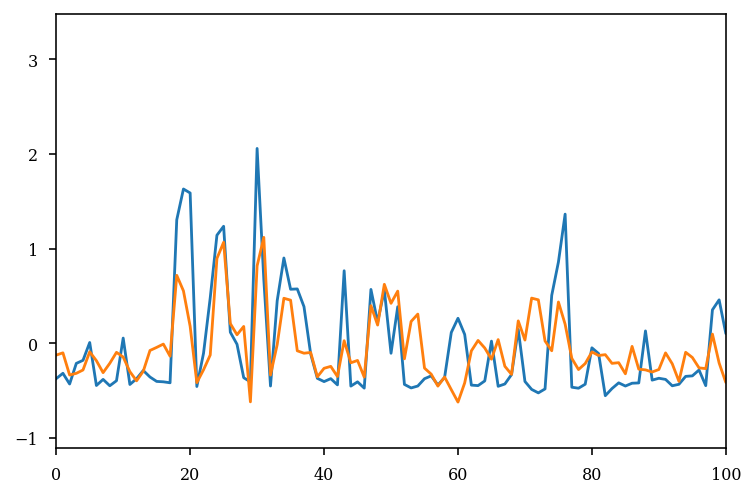

In [42]:
plt.plot(y_test[:,1])
plt.plot(mdl.predict(X_test))
plt.xlim(0,100)
plt.show()

[0.172992   0.20533444 0.12658933 0.10600705 0.10289255 0.05506217
 0.59642107 0.06732173 0.18708859 0.09768241 0.08545485 0.0658052
 3.07011456 0.10846125 0.1665033  0.24984323 0.09239482 0.57343649
 0.12259232 0.14711055 0.20243127 0.05189248 3.54754271 1.02254737
 0.33873317 0.10197997 1.24289811 0.36141365 3.22631905 0.16794326
 2.06966628 2.29668307 0.17148406 0.10580914 0.20862729 3.81643424
 0.43019852 0.09935815 4.89434684 1.80586687 4.22415238 0.34243454
 2.56293956 0.33854385 0.85158413 3.08440918 0.27309931 0.99240426
 0.27141758 0.23050299 0.22517342 0.23953013 0.13806953 0.51279378
 0.10163189 0.12694544 0.04852304 0.15016592 0.12020366 0.16915312
 0.0140058  0.16252045 0.00874423 0.16120996 0.14601955 0.06503377
 0.09173222 0.34801113 0.29745676 0.17760673 0.15457572 0.289261
 0.41181942 0.09782566 0.39842463 0.02383199 1.72286741 0.24363425
 0.31713279 0.53078863 0.04651932 1.13819702 0.09327105 0.12681211
 0.63476838]


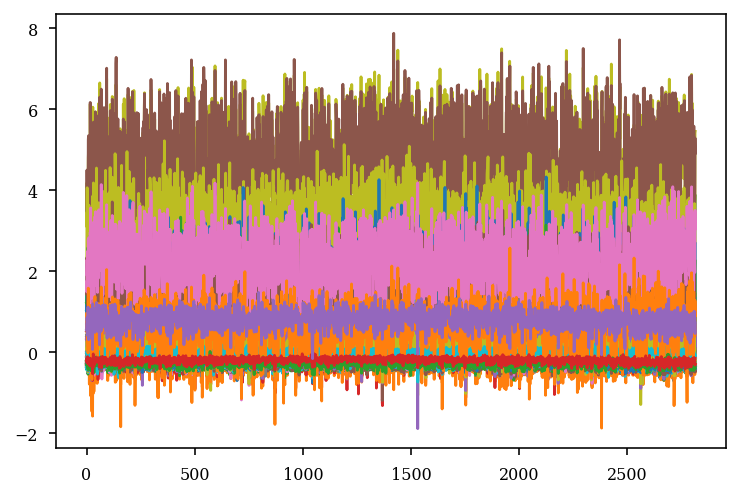

In [108]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor # r2=-0.018973739390232502
from sklearn.ensemble import ExtraTreesRegressor # 0.03416178792254043
from sklearn.linear_model import LinearRegression # mse=0.20533444

regr = LinearRegression()

regr.fit(X_train, y_train)
# print(regr.score(X_test, y_test,multioutput='raw_values'))
print(mean_squared_error(y_test, regr.predict(X_test), multioutput='raw_values'))

# plt.plot(y_test)
plt.plot(regr.predict(X_test))
# plt.xlim(0,100)
plt.show()

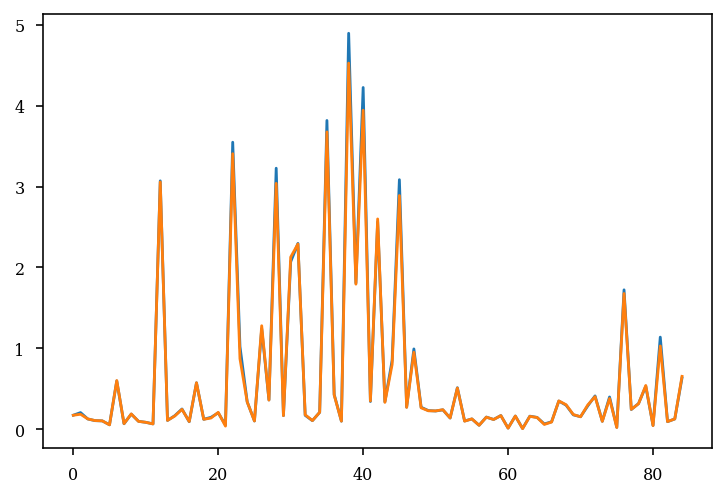

In [110]:
regr = LinearRegression()
regr.fit(X_train, y_train)
plt.plot(mean_squared_error(y_test, regr.predict(X_test), multioutput='raw_values'))


regr = ExtraTreesRegressor()
regr.fit(X_train, y_train)
plt.plot(mean_squared_error(y_test, regr.predict(X_test), multioutput='raw_values'))


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from ripple_heterogeneity.utils import kernel_reduced_rank_ridge_regression
from sklearn.multioutput import MultiOutputRegressor

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
# pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
# pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', MultiOutputRegressor(GradientBoostingRegressor()))])))
# pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
pipelines.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
# pipelines.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
pipelines.append(('ScaledBagging', Pipeline([('Scaler', StandardScaler()),('BAG', BaggingRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
# pipelines.append(('ScaledMLP', Pipeline([('Scaler', StandardScaler()),('MLP', MLPRegressor())])))
pipelines.append(('ScaledRRRR', Pipeline([('Scaler', StandardScaler()),('RRRR', kernel_reduced_rank_ridge_regression.ReducedRankRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [96]:
svr = GridSearchCV(
    SVR(kernel="rbf", gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
)

(4221, 85)

In [ ]:
pipelines = []
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []

for cell_i in range(y_train.shape[1]):
    for name, model in pipelines:
        kfold = KFold(n_splits=10)
        cv_results = cross_val_score(model, X_train, y_train[:,cell_i], cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

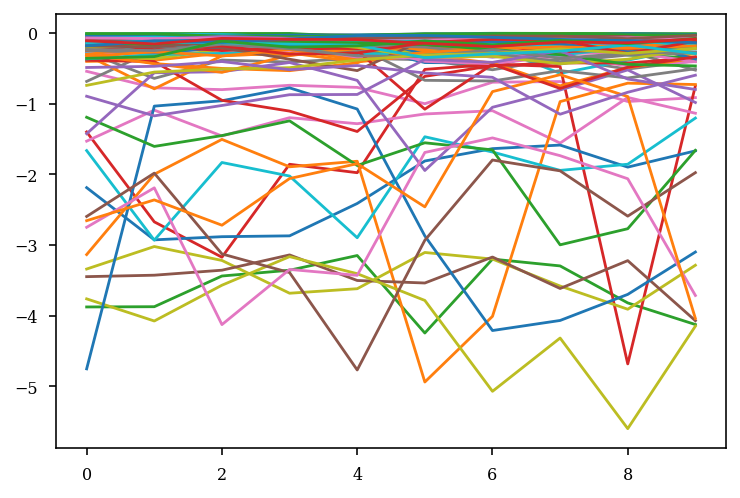

In [101]:
plt.plot(np.array(results).T)
plt.show()

In [89]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, y_train[:,1])

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.329447 (0.095420) with: {'n_estimators': 50}
-0.329477 (0.086888) with: {'n_estimators': 100}
-0.331350 (0.080776) with: {'n_estimators': 200}
-0.332626 (0.077874) with: {'n_estimators': 300}
-0.334932 (0.077178) with: {'n_estimators': 400}
Best: -0.329447 using {'n_estimators': 50}


In [91]:
from sklearn.metrics import mean_squared_error

scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=21, n_estimators=50)
model.fit(rescaled_X_train, y_train[:,1])

# transform the validation dataset
rescaled_X_test = scaler.transform(X_test)
predictions = model.predict(rescaled_X_test)
print(mean_squared_error(y_test[:,1], predictions))

0.19321581955950554


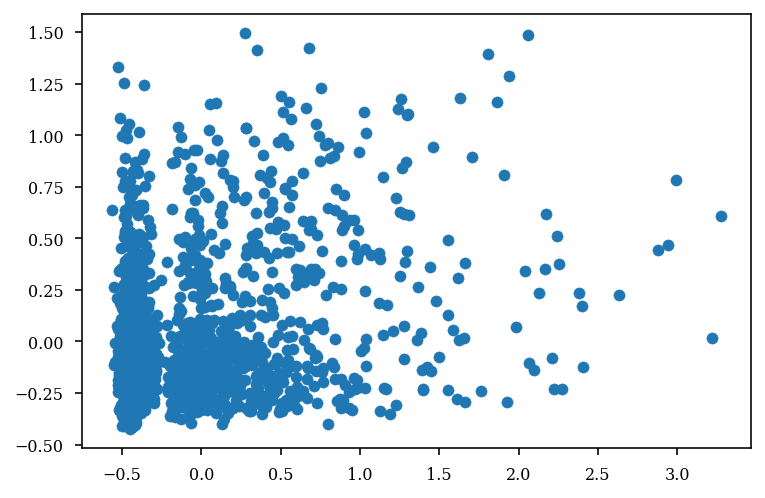

In [44]:
plt.scatter(y_test[:,1], regr.predict(X_test))

In [45]:
from ripple_heterogeneity.utils import (
    functions,
    compress_repeated_epochs,
    loading,
    add_new_deep_sup,
    reduced_rank_regressor,
    kernel_reduced_rank_ridge_regression,
)

grid_search = predict_downstream_reduced_rank_regressor.run_grid_search(
    X_train, y_train, n_grid=20, cv=5, max_rank=64
)


In [48]:
regressor = (
    kernel_reduced_rank_ridge_regression.ReducedRankRegressor()
)
regressor.rank = int(grid_search.best_params_["rank"])
regressor.reg = 1
regressor.fit(X_train, y_train)

In [58]:
mean_squared_error(y_test, regressor.predict(X_test))

0.6992705086937967

In [53]:
y_test.shape, regressor.predict(X_test).shape

((2815, 85), (2815, 85))

In [62]:
from sklearn.metrics import r2_score
mse = []
r2 = []
y_pred = regressor.predict(X_test)
for i in range(y_test.shape[1]):

    mse.append(mean_squared_error(y_test[:,i], y_pred[:,i]))
    r2.append(r2_score(y_test[:,i], y_pred[:,i]))

In [69]:
mean_squared_error(y_test, y_pred,multioutput='raw_values')

array([0.17113891, 0.21188473, 0.1273601 , 0.109537  , 0.10820879,
       0.05474104, 0.59846977, 0.06955721, 0.19101865, 0.10015946,
       0.08719403, 0.06884581, 3.05200206, 0.10922578, 0.16690172,
       0.24912796, 0.09770202, 0.58048854, 0.12067983, 0.13054097,
       0.20234928, 0.05472592, 4.21381683, 1.01813428, 0.3410198 ,
       0.10454109, 1.29779635, 0.36097855, 4.60951331, 0.16748443,
       2.22065966, 2.26331095, 0.17519584, 0.10994907, 0.21009418,
       4.98311611, 0.43271654, 0.10333384, 5.04192925, 1.84345393,
       4.50050103, 0.3363735 , 2.77227676, 0.31685441, 0.8560986 ,
       2.88070581, 0.2817383 , 1.02238618, 0.26807394, 0.23345832,
       0.22306425, 0.23655423, 0.14132341, 0.51743738, 0.1025746 ,
       0.12701649, 0.05189002, 0.1514898 , 0.1196841 , 0.16198359,
       0.01802019, 0.16265492, 0.01253662, 0.16191507, 0.14828748,
       0.06348468, 0.09206331, 0.35161155, 0.30033833, 0.18603659,
       0.15313155, 0.29465197, 0.41027584, 0.09640959, 0.39108

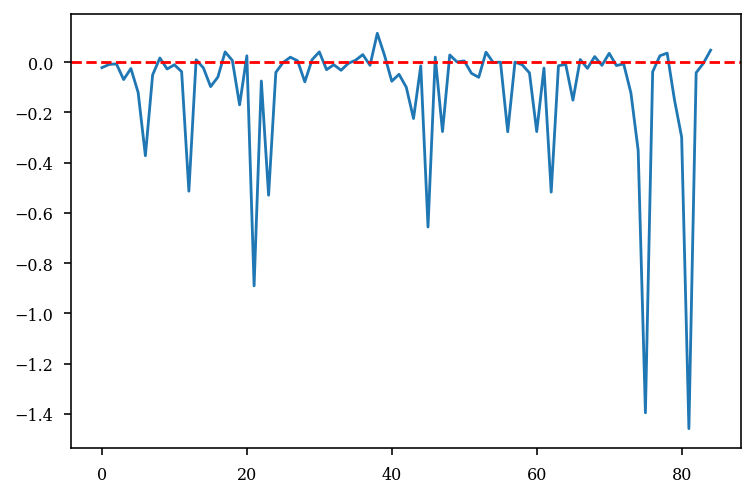

In [77]:
plt.plot(r2_score(y_test, y_pred,multioutput='raw_values'))
plt.axhline(0, color='r', linestyle='--')

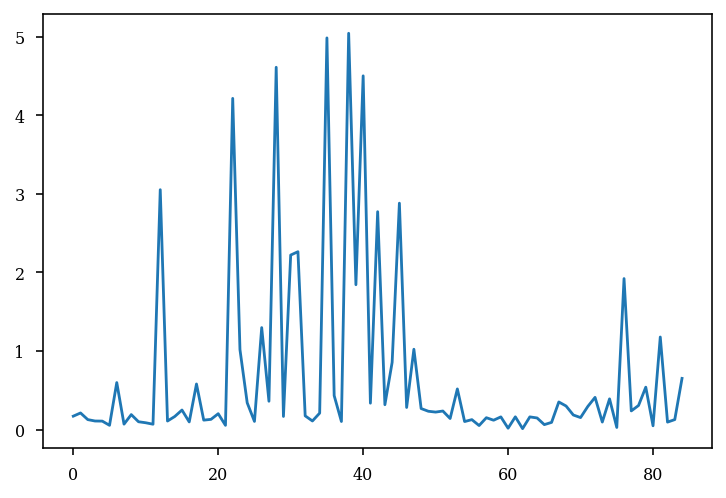

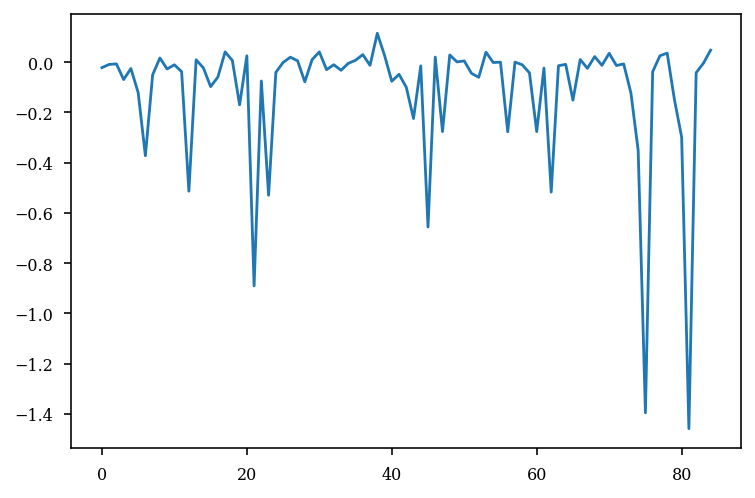

In [66]:
plt.plot(mse)
plt.show()
plt.plot(r2)


## testing out different temp file naming scheme

In [4]:
basepath = r"Z:\Data\Can\OML23\day3"
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\batch_testing_name"

save_file = os.path.join(
    save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"
)
save_file

'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\batch_testing_name\\Z__Data_Can_OML23_day3.pkl'

In [12]:
animal,day = os.path.split(basepath)
os.path.split(animal)

('Z:\\Data\\Can', 'OML23')

In [ ]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\batch_testing_name"

batch_analysis.run(
    df_sessions,
    save_path,
    predict_downstream_reduced_rank_regressor.run,
    parallel=True,
    verbose=False,
    num_cores=12,
    skip_if_error=False,
    n_shuff=500,
    source_cell_type="Pyr|Int",
    use_entire_session=True
)